# Interpret the model

In [1]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
from eugene import models
import matplotlib.pyplot as plt
import seqdata as sd
from eugene import plot as pl
import sys
sys.path.append('/cellar/users/aklie/projects/ML4GLand/collabs/er_stress_regulation/scripts')
from DeepMEL import DeepMEL

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
dataset_name = "multiome_cells_all_peaks"
data_dir = f"/cellar/users/aklie/data/ml4gland/collabs/er_stress_regulation/{dataset_name}"
models_dir = "/cellar/users/aklie/projects/ML4GLand/collabs/er_stress_regulation/models"

In [3]:
test_sdata = sd.open_zarr(os.path.join(data_dir, f"{dataset_name}.test.zarr"))

In [4]:
os.path.join(models_dir, dataset_name, "multiome_cells_all_peaks.DeepMEL.revision/v0/checkpoints/epoch=15-step=16080.ckpt")

'/cellar/users/aklie/projects/ML4GLand/collabs/er_stress_regulation/models/multiome_cells_all_peaks/multiome_cells_all_peaks.DeepMEL.revision/v0/checkpoints/epoch=15-step=16080.ckpt'

In [5]:
arch = DeepMEL(
    input_len=500, 
    output_dim=37,
    conv_kwargs={
        "conv_channels": [1024],  
    },
)

In [6]:
model = models.SequenceModule.load_from_checkpoint(
    os.path.join(models_dir, dataset_name, "multiome_cells_all_peaks.DeepMEL.revision/v0/checkpoints/epoch=15-step=16080.ckpt"),
    arch=arch,
)

In [7]:
import torch
import seqexplainer as se

In [8]:
topic_num = 16

In [62]:
import gc
gc.collect()
# clear cuda cache
torch.cuda.empty_cache()

# report memory allocated on GPU
print(torch.cuda.memory_allocated() / 1e9)

4.631658496


In [63]:
explains = se.attribute(
    model,
    inputs=torch.tensor(test_sdata["ohe_seqs"].values.transpose(0, 2, 1), dtype=torch.float32),
    method="GradientShap",
    target=topic_num-1,
    reference_type="shuffle",
    device="cuda",
    batch_size=128
)

Computing attributions on batches of size 128:   0%|          | 0/86 [00:00<?, ?it/s]

In [33]:
test_preds = model.predict(test_sdata["ohe_seqs"].transpose("_sequence", "_ohe", "length").values, batch_size=512)

Predicting on batches:   0%|          | 0/21 [00:00<?, ?it/s]

In [64]:
test_preds = test_preds.cpu().numpy()

AttributeError: 'numpy.ndarray' object has no attribute 'cpu'

In [ ]:
top5_ind = np.argsort(test_preds[:, topic_num-1])[::-1][:5]

In [ ]:
test_preds[top5_ind]

array([[-0.86238384, -1.2923378 , -0.6247158 , -1.0936787 , -1.9966075 ,
        -1.1248903 , -1.5185583 , -1.0341578 , -0.94406927, -0.74061674,
        -1.1718446 , -1.4123065 , -1.890315  , -0.7706033 , -1.2444396 ,
         0.31059927, -1.0782155 ,  0.26975018, -0.5787536 , -0.39869004,
        -1.3175818 , -1.3041    , -1.4805845 , -1.1392126 , -1.2955048 ,
        -0.72481567, -0.9064734 , -0.9419329 , -0.9298063 , -0.72088456,
        -1.4334849 , -0.96615404, -0.7318101 , -0.54251564, -1.0547558 ,
        -1.8462455 , -0.25825873],
       [-0.8537939 , -1.2714794 , -0.57383966, -1.0705574 , -1.9678587 ,
        -1.0675435 , -1.4814544 , -1.0222495 , -0.9412141 , -0.7188993 ,
        -1.1742306 , -1.4097121 , -1.8866174 , -0.7838608 , -1.2159637 ,
         0.3057126 , -1.065044  ,  0.25847083, -0.6058996 , -0.3806371 ,
        -1.327965  , -1.2862651 , -1.4266571 , -1.0914568 , -1.2554165 ,
        -0.6583729 , -0.86914074, -0.9180877 , -0.90785336, -0.70985913,
        -1.41761

In [ ]:
top5_explains = explains[list(top5_ind)]

In [ ]:
top5_ind.shape, top5_explains.shape

((5,), (5, 4, 500))

In [ ]:
import tfomics
import matplotlib.pyplot as plt

In [ ]:
def plot_saliency_map(explains, sort, width=13, height_per_explain=1):
    """
    Plot the saliency maps for each sequence
    """
    num_plot = len(explains)
    fig = plt.figure(figsize=(width, num_plot*height_per_explain))
    for i in range(num_plot):
        ax = plt.subplot(num_plot, 1, i+1)
        saliency_df = pd.DataFrame(explains[i].transpose([1,0]), columns=["A","C","G","T"])
        saliency_df.index.name = "pos"
        tfomics.impress.plot_attribution_map(saliency_df, ax, figsize=(num_plot,1))
        plt.ylabel(sort[i])

In [ ]:
plot_saliency_map?

Signature: plot_saliency_map(explains, sort, width=13, height_per_explain=1)
Docstring: Plot the saliency maps for each sequence
File:      /tmp/ipykernel_3153301/2255502963.py
Type:      function

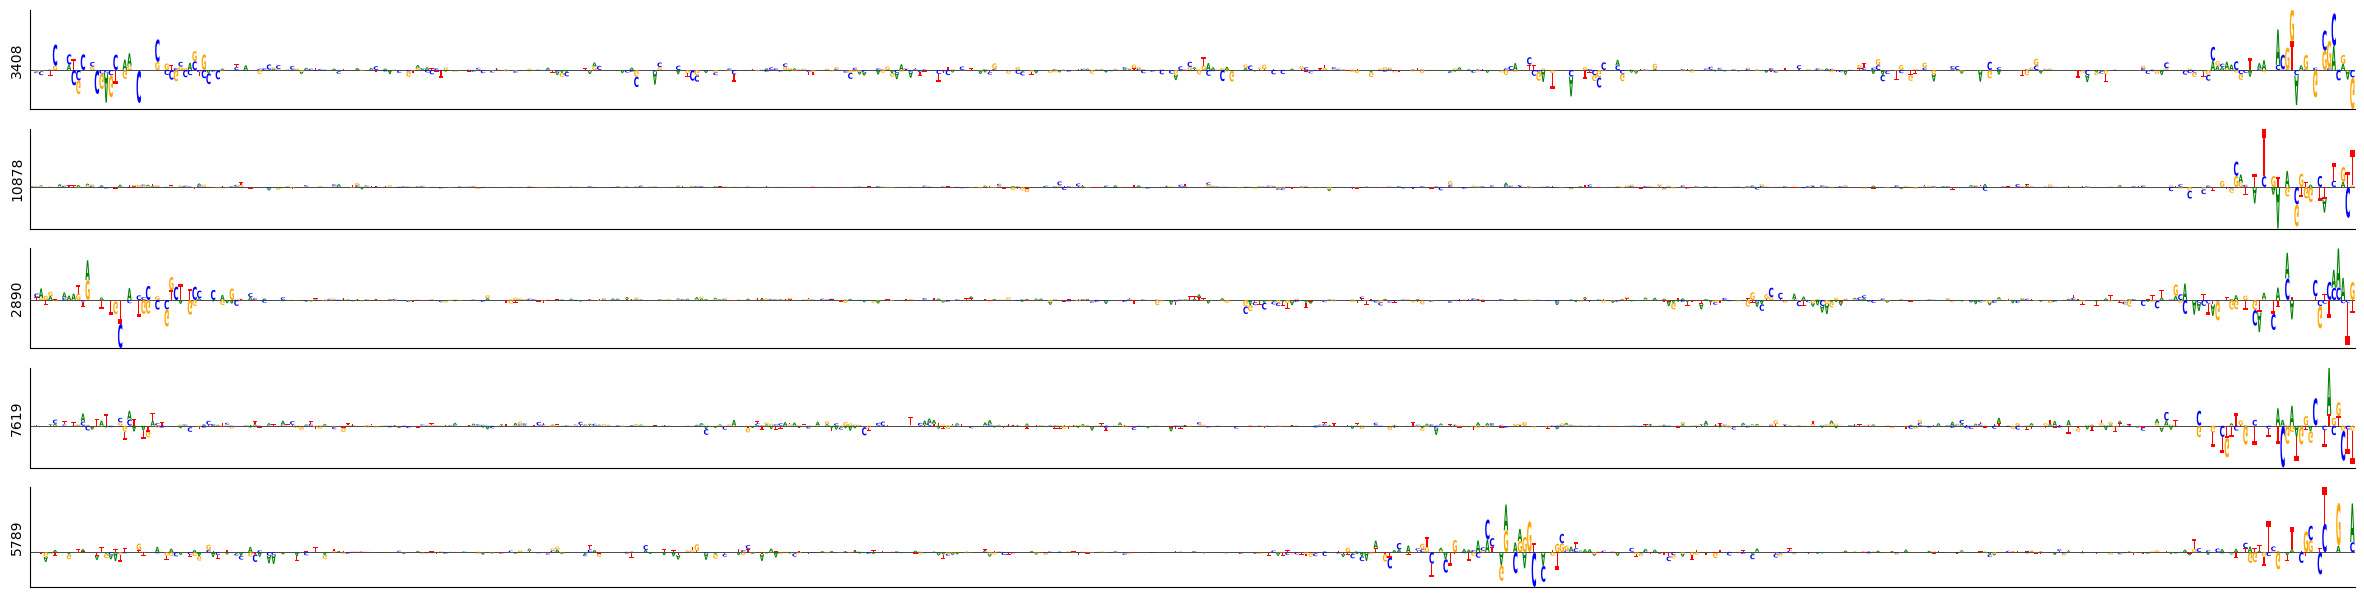

In [ ]:
plot_saliency_map(explains[:5], top5_ind, width=30, height_per_explain=1.5)
plt.show()

In [ ]:
output_dir = f'/cellar/users/aklie/projects/EUGENe_use_cases/er_stress_regulation/interpret/Topic{topic_num}'

In [ ]:
pos_patterns, neg_patterns = seqexplainer.modisco(
    one_hot=sdata_test.ohe_seqs,
    hypothetical_contribs=explains.detach().cpu().numpy(),
    output_dir=output_dir,
    output_name=f"DeepSTRESS_30v2_modisco_topic{topic_num}.h5",
)

In [ ]:
seqexplainer.modisco_logos(
    modisco_h5_file=os.path.join(output_dir, f"DeepSTRESS_30v2_modisco_topic{topic_num}.h5"),
    output_dir=os.path.join(output_dir, "topic1_logos"),
)

['pos_patterns.pattern_0',
 'pos_patterns.pattern_1',
 'pos_patterns.pattern_2',
 'pos_patterns.pattern_3',
 'pos_patterns.pattern_4',
 'pos_patterns.pattern_5',
 'neg_patterns.pattern_0',
 'neg_patterns.pattern_1',
 'neg_patterns.pattern_2',
 'neg_patterns.pattern_3',
 'neg_patterns.pattern_4',
 'neg_patterns.pattern_5',
 'neg_patterns.pattern_6',
 'neg_patterns.pattern_7',
 'neg_patterns.pattern_8',
 'neg_patterns.pattern_9',
 'neg_patterns.pattern_10',
 'neg_patterns.pattern_11',
 'neg_patterns.pattern_12',
 'neg_patterns.pattern_13',
 'neg_patterns.pattern_14',
 'neg_patterns.pattern_15',
 'neg_patterns.pattern_16',
 'neg_patterns.pattern_17',
 'neg_patterns.pattern_18',
 'neg_patterns.pattern_19',
 'neg_patterns.pattern_20']

In [ ]:
seqexplainer.modisco_report(
    modisco_h5_file=os.path.join(output_dir, f"DeepSTRESS_30v2_modisco_topic{topic_num}.h5"),
    meme_db_file="/cellar/users/aklie/data/shared/meme/motif_databases/HUMAN/HOCOMOCOv11_core_HUMAN_mono_meme_format.meme",
    output_dir=os.path.join(output_dir, "report"),
    top_n_matches=2,
    trim_threshold=0.3,
    trim_min_length=3,
)